# UTILS SCRIPT

In [2]:
# Script 
import os
import cv2
import numpy as np
import SimpleITK as sitk
from scipy.stats import pearsonr


def all_files_under(path, extension='png', append_path=True, sort=True):
    if append_path:
        if extension is None:
            filenames = [os.path.join(path, fname) for fname in os.listdir(path)]
        else:
            filenames = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith(extension)]
    else:
        if extension is None:
            filenames = [os.path.basename(fname) for fname in os.listdir(path)]
        else:
            filenames = [os.path.basename(fname) for fname in os.listdir(path) if fname.endswith(extension)]

    if sort:
        filenames = sorted(filenames)

    return filenames


def histogram(img, bins=256):
    h, w = img.shape
    hist = np.zeros(bins)
    for i in range(h):
        for j in range(w):
            a = img.item(i, j)
            hist[a] += 1

    return hist


def cumulative_histogram(hist, bins=256):
    cum_hist = hist.copy()
    for i in range(1, bins):
        cum_hist[i] = cum_hist[i-1] + cum_hist[i]

    return cum_hist


def n4itk(img):
    ori_img = img.copy()
    mr_img = sitk.GetImageFromArray(img)
    mask_img = sitk.OtsuThreshold(mr_img, 0, 1, 200)

    # Convert to sitkFloat32
    mr_img = sitk.Cast(mr_img, sitk.sitkFloat32)
    # N4 bias field correction
    num_fitting_levels = 4
    num_iters = 200
    try:
        corrector = sitk.N4BiasFieldCorrectionImageFilter()
        corrector.SetMaximumNumberOfIterations([num_iters] * num_fitting_levels)
        cor_img = corrector.Execute(mr_img, mask_img)
        cor_img = sitk.GetArrayFromImage(cor_img)

        cor_img[cor_img<0], cor_img[cor_img>255] = 0, 255
        cor_img = cor_img.astype(np.uint8)
        return ori_img, cor_img  # return origin image and corrected image
    except (RuntimeError, TypeError, NameError):
        print('[*] Catch the RuntimeError!')
        return ori_img, ori_img


def histogram_matching(img, ref, bins=256):
    assert img.shape == ref.shape

    result = img.copy()
    h, w = img.shape
    pixels = h * w

    # histogram
    hist_img = histogram(img)
    hist_ref = histogram(ref)
    # cumulative histogram
    cum_img = cumulative_histogram(hist_img)
    cum_ref = cumulative_histogram(hist_ref)
    # normalization
    prob_img = cum_img / pixels
    prob_ref = cum_ref / pixels

    new_values = np.zeros(bins)
    for a in range(bins):
        j = bins - 1
        while True:
            new_values[a] = j
            j = j - 1

            if j < 0 or prob_img[a] >= prob_ref[j]:
                break

    for i in range(h):
        for j in range(w):
            a = img.item(i, j)
            b = new_values[a]
            result.itemset((i, j), b)

    return result


def get_mask(image, task='m2c'):
    # Bilateral Filtering
    # img_blur = cv2.bilateralFilter(image, 5, 75, 75)
    img = image.copy()
    # gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)    
    th, img_thr = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    img_mor = img_thr.copy()

    # For loop closing
    for ksize in range(21, 3, -2):
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))
        img_mor = cv2.morphologyEx(img_mor, cv2.MORPH_CLOSE, kernel)

    # Copy the thresholded image.
    im_floodfill = img_mor.copy()

    # Mask used to flood filling.
    # Notice the size needs to be 2 pixels than the image.
    h, w = img_mor.shape
    mask = np.zeros((h + 2, w + 2), np.uint8)

    # Floodfill from point (0,0)
    cv2.floodFill(im_floodfill, mask, (0, 0), 255)

    # Invert floodfilled image
    img_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    pre_mask = img_mor | img_floodfill_inv

    # Find the biggest contour
    mask = np.zeros((h, w), np.uint8)
    max_pix, max_cnt = 0, None
    contours, hierachy = cv2.findContours(pre_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        num_pix = cv2.contourArea(cnt)
        if num_pix > max_pix:
            max_pix = num_pix
            max_cnt = cnt

    cv2.drawContours(mask, [max_cnt], 0, 255, -1)

    if task.lower() == 'm2c':
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        mask = cv2.dilate(mask, kernel, iterations=2)

    return mask


def cal_mae(gts, preds):
    num_data, h, w, _ = gts.shape
    # mae = np.sum(np.abs(preds - gts)) / (num_data * h * w)
    mae = np.mean(np.abs(preds - gts))

    return mae

def cal_me(gts, preds):
    num_data, h, w, _ = gts.shape
    # me = np.sum(preds - gts) / (num_data * h * w)
    me = np.mean(preds - gts)

    return me

def cal_mse(gts, preds):
    num_data, h, w, _ = gts.shape
    # mse = np.sum(np.abs(preds - gts)**2) / (num_data * h * w)
    mse = np.mean((np.abs(preds - gts))**2)
    return mse

def cal_pcc(gts, preds):
    pcc, _ = pearsonr(gts.ravel(), preds.ravel())
    return pcc

# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
import tensorflow as tf
from tensorflow import keras
from scipy.stats import pearsonr
from PIL import Image

# Accessing dataset

Load image path and store it as an array of filenames

In [3]:
# Dividing dataset into train, test and validation data
data = '/kaggle/input/mrct-pair/'

# All files 
filenames = all_files_under(data+'raw', extension='png')
mri_files = all_files_under(data+'mri', extension = 'png')
ct_files = all_files_under(data+'ct', extension = 'png')
mask_files = all_files_under(data+'mask', extension = 'png')
preprocessed_files = all_files_under(data+'preprocessing', extension = 'png')
post_files = all_files_under(data+'post', extension = 'png')

# Preprocessing images

Our dataset contains images of CT-MR pairs. We need to preprocess these images and save them in separate folders. During preprocessing, corresponding masks of the images are also generated and saved in a separate folder.

In [4]:
# temp_id = template image id for histogram matching
save_path = '/kaggle/working/'
def imshow(ori_mr, cor_mr, his_mr, masked_mr, mask, ori_ct, masked_ct, size=256, delay=0, himgs=2, wimgs=5, margin=5):
    """
    Input parameters:
    ori_mr : Original MR image
    cor_mr: N4ITK corrected MR image
    his_mr: Histogram matched MR image
    masked_mr: Mask of the MR image
    ori_ct: Original CT image
    masked_ct: Mask of the CT image

    Result: A concatenated image of each preprocessing step output
    """
    canvas = 255 * np.ones((himgs * size + (himgs-1) * margin, wimgs * size + (wimgs-1) * margin), dtype=np.uint8)

    first_rows = [ori_mr, cor_mr, his_mr, masked_mr, mask]
    second_rows = [ori_ct, 255*np.ones(ori_ct.shape), 255*np.ones(ori_ct.shape), masked_ct, mask]
    for idx in range(len(first_rows)):
        canvas[:size, idx*(margin+size):idx*(margin+size)+size] = first_rows[idx]
        canvas[-size:, idx*(margin+size):idx*(margin+size)+size] = second_rows[idx]

    # "N4 Bias Field Correction",
    # cv2_imshow( canvas)
    if cv.waitKey(delay) & 0XFF == 27:
        sys.exit('[*] Esc clicked!')

    return canvas

def main(data, temp_id=2, size=256, delay=0, is_save=True):
    """
    Takes the dataset path as input parameter.
    """
    preprocessing_folder = os.path.join(os.path.dirname(data), 'preprocessing')
    if is_save and not os.path.exists(preprocessing_folder):
        os.makedirs(preprocessing_folder)

    post_folder = os.path.join(os.path.dirname(data), 'post')
    if is_save and not os.path.exists(post_folder):
        os.makedirs(post_folder)

    ct_folder = os.path.join(os.path.dirname(data), 'ct')
    if is_save and not os.path.exists(ct_folder):
        os.makedirs(ct_folder)
    
    mri_folder = os.path.join(os.path.dirname(data), 'mri')
    if is_save and not os.path.exists(mri_folder):
        os.makedirs(mri_folder)
    
    mask_folder = os.path.join(os.path.dirname(data), 'mask')
    if is_save and not os.path.exists(mask_folder):
        os.makedirs(mask_folder)


    # read all files paths
    filenames = all_files_under(data, extension='png')

    # read template image
    temp_filename = filenames[temp_id]
    ref_img = cv.imread(temp_filename, cv.IMREAD_GRAYSCALE)
    ref_img = ref_img[:, -size:].copy()
    _, ref_img = n4itk(ref_img)  # N4 bias correction for the reference image

    for idx, filename in enumerate(filenames):
        # print('idx: {}, filename: {}'.format(idx, filename))

        img = cv.imread(filename, cv.IMREAD_GRAYSCALE)
        ct_img = img[:, :size]
        mr_img = img[:, -size:]

        # N4 bias correction
        ori_img, cor_img = n4itk(mr_img)
        # Dynamic histogram matching between two images
        his_mr = histogram_matching(cor_img, ref_img)
        # Mask estimation based on Otsu auto-thresholding
        mask=get_mask(his_mr, task='m2c')
        # Masked out
        masked_ct = ct_img & mask
        masked_mr = his_mr & mask
        canvas = imshow(ori_img, cor_img, his_mr, masked_mr, mask, ct_img, masked_ct, size=size, delay=delay)
        canvas2 = np.hstack((masked_mr, masked_ct, mask))

        if is_save:
            cv.imwrite(os.path.join(preprocessing_folder, os.path.basename(filename)), canvas)
            cv.imwrite(os.path.join(post_folder, os.path.basename(filename)), canvas2)
            cv.imwrite(os.path.join(ct_folder, os.path.basename(filename)), masked_ct)
            cv.imwrite(os.path.join(mri_folder, os.path.basename(filename)), masked_mr)
            cv.imwrite(os.path.join(mask_folder, os.path.basename(filename)), mask)
# main('/kaggle/working/')

# Data Visualization

First we visualise the raw CT-MR pair images

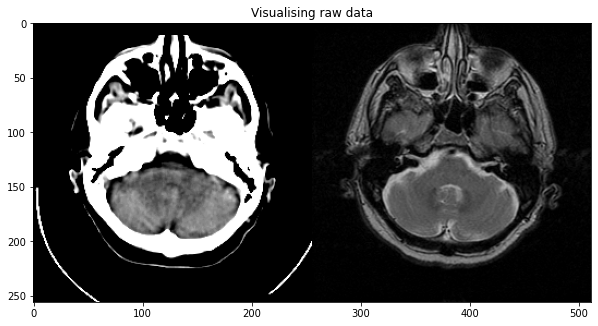

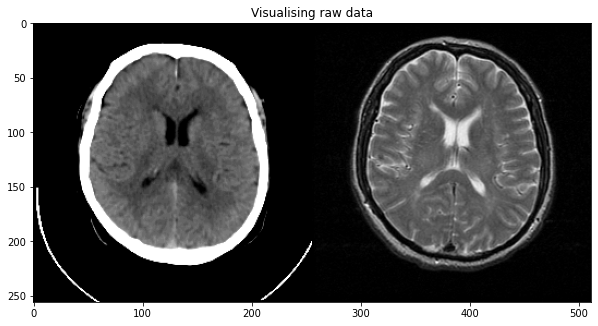

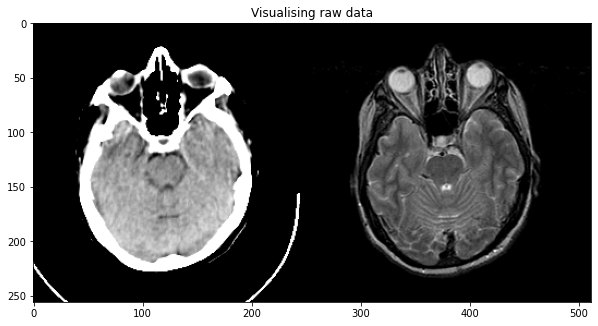

In [5]:
# Visualizing the first few images in the dataset
for i in range(3):
  plt.figure(figsize=(10,10))
  image = filenames[i]
  img = cv.imread(image)
  plt.imshow(img, cmap='gray')
  plt.title("Visualising raw data")
  plt.show()

## Preprocessed Data

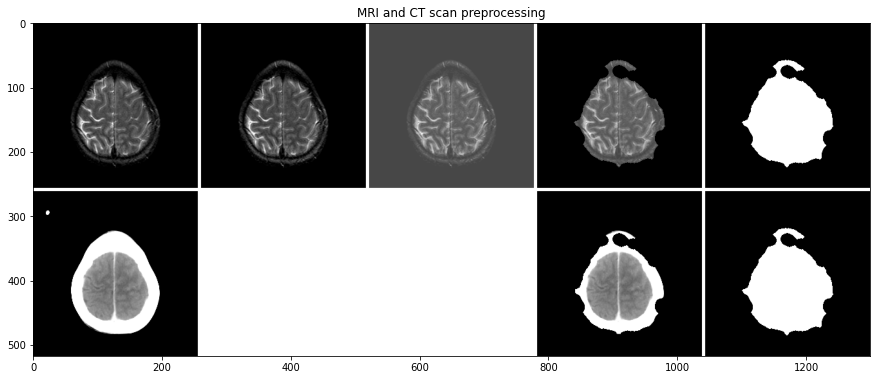

In [6]:
# cv2_imshow(preprocessed)
plt.figure(figsize=(15,15))
index=np.random.randint(1,len(preprocessed_files))
preprocessed = cv.imread(preprocessed_files[index])
plt.imshow(preprocessed, cmap="gray")
plt.title("MRI and CT scan preprocessing")
plt.show()

## Post Processed Data

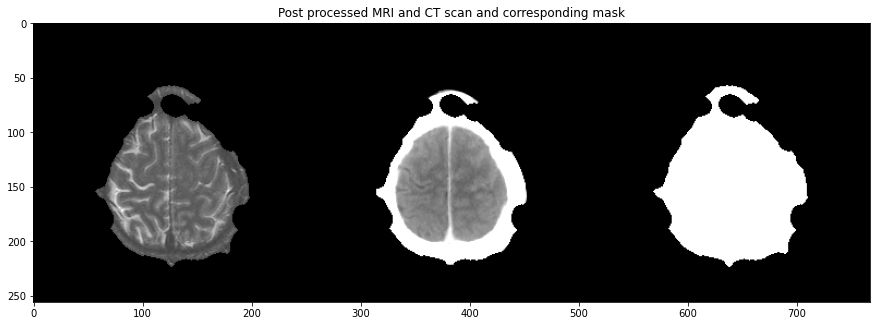

In [7]:
plt.figure(figsize=(15,15))
post = cv.imread(post_files[index])
plt.imshow(post, cmap="gray")
plt.title("Post processed MRI and CT scan and corresponding mask")
plt.show()

# Create data frame and split data on train set, validation set and test set

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.DataFrame(data={"mri": mri_files, 'ct' : ct_files})
df_train, df_test = train_test_split(df,test_size = 0.128)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(256, 2)
(64, 2)
(47, 2)


# Data generator, data augmentation and adjust data

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize data

def adjust_data(img,ct):
    img = img / 255
    mask = ct / 255
#     mask[mask > 0.5] = 1
#     mask[mask <= 0.5] = 0    

    return (img, mask)

def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
#         mask_color_mode="grayscale",
        mri_save_prefix="mri",
        ct_save_prefix="ct",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate mri and ct image at the same time use the same seed for
    image_datagen and ct_datagen to ensure the transformation for mri
    and ct image is the same.If you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    mri_datagen = ImageDataGenerator(**aug_dict)
    ct_datagen = ImageDataGenerator(**aug_dict)
#     mask_datagen = ImageDataGenerator(**aug_dict)

    mri_generator = mri_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mri",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mri_save_prefix,
        seed = seed)
    ct_generator = mri_datagen.flow_from_dataframe(
        data_frame,
        x_col = "ct",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = ct_save_prefix,
        seed = seed)
#     mask_generator = mask_datagen.flow_from_dataframe(
#         data_frame,
#         x_col = "mask",
#         class_mode = None,
#         color_mode = mask_color_mode,
#         target_size = target_size,
#         batch_size = batch_size,
#         save_to_dir = save_to_dir,
#         save_prefix  = mask_save_prefix,
#         seed = seed)

    train_gen = zip(mri_generator, ct_generator)
    
    for (mri, ct) in train_gen:
        mri, ct = adjust_data(mri, ct)
        yield (mri,ct)

# Define loss function and metrics

In [10]:
from tensorflow import keras

In [11]:
from tensorflow.keras import backend as K
smooth=100

tf.compat.v1.disable_eager_execution()
from tensorflow.keras.applications import VGG19


def perceptual_loss_vgg19(y_true, y_pred):
    # must ensure that y_true and y_pred come from same distribution
    # nice to have - similar distribution to vgg19 inputs
    y_pred = tf.image.grayscale_to_rgb(y_pred, name=None) #need to convert as UNet outputs single channel
    vgg = VGG19(include_top=False, weights="imagenet", input_shape=(256, 256, 3))
    loss_model = Model(
        inputs=vgg.input, outputs=vgg.get_layer("block3_conv3").output
    )
    return K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))

# Defining Model Architecture

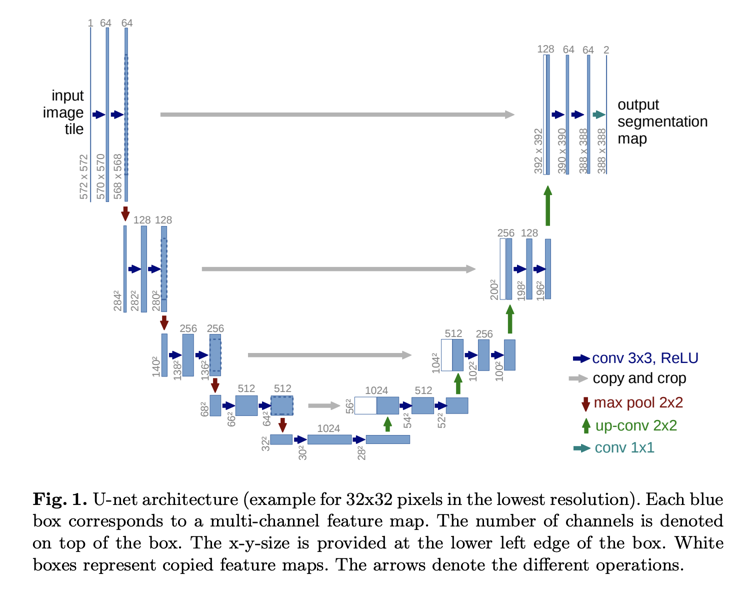

In [12]:
# Visualize the UNET architecture
url = 'https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png'
from PIL import Image
import requests
from io import BytesIO
response = requests.get(url)
image = Image.open(BytesIO(response.content))
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

## Import Libraries for Model Build

In [13]:
# from keras.utils import get_file
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [14]:
# Defining the architectural blocks

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg19_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg19.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg19.get_layer("block3_conv3").output         ## (128 x 128)
    s4 = vgg19.get_layer("block4_conv3").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg19.get_layer("block5_conv3").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model

Here for encoder part of UNET architecture, we use a pretrained weight.

## Build Model

In [16]:
input_size = (256,256,3)

vgg19_unet = build_vgg19_unet(input_size)
vgg19_unet.summary()

Model: "VGG19_U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
________________________________________________________________________________________

# Train

## Generate training and validation data

In [17]:
EPOCHS = 500
BATCH_SIZE = 32
learning_rate = 1e-4
decay_rate = learning_rate / EPOCHS
STEPS_PER_EPOCH = len(df_train) / BATCH_SIZE
SAVE_PERIOD = 50

In [18]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(256, 256))
    
val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(256, 256))

test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(256, 256))

## Load Saved Model

In [35]:
from tensorflow.keras.models import load_model

model_path = '/kaggle/working/model_unet256_vgg19.500.hdf5'
try:
    model = load_model(model_path, compile=False)
except OSError:
    model = vgg19_unet

## Compile Model

In [37]:
# Save model every 10 epochs
model_file_format = "model_unet256_vgg19.{epoch:03d}.hdf5"
opt = keras.optimizers.Adam(learning_rate=learning_rate,beta_1=0.9, beta_2=0.999, epsilon = 0.01, decay=decay_rate, amsgrad=False)
checkpointer = ModelCheckpoint(model_file_format, verbose=1, save_freq= int(SAVE_PERIOD * STEPS_PER_EPOCH))

model.compile(optimizer=opt, loss=perceptual_loss_vgg19, metrics=[perceptual_loss_vgg19,"accuracy"])

## Start Training

In [ ]:
# vgg16_unet = keras.models.load_model(path)
history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks = [checkpointer],
                    validation_data = val_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 256 validated image filenames.
Found 256 validated image filenames.
Epoch 1/500


2022-12-25 15:59:42.843481: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


8/8 [==============================] - ETA: 0s - batch: 3.5000 - size: 32.0000 - loss: 25.2449 - perceptual_loss_vgg19: 25.2449 - accuracy: 0.6072Found 64 validated image filenames.
Found 64 validated image filenames.


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


8/8 [==============================] - 33s 1s/step - batch: 3.5000 - size: 32.0000 - loss: 25.2449 - perceptual_loss_vgg19: 25.2449 - accuracy: 0.6072 - val_loss: 34.4942 - val_perceptual_loss_vgg19: 34.4942 - val_accuracy: 0.1487
Epoch 2/500
8/8 [==============================] - 10s 1s/step - batch: 3.5000 - size: 32.0000 - loss: 19.7991 - perceptual_loss_vgg19: 19.7991 - accuracy: 0.6149 - val_loss: 34.5278 - val_perceptual_loss_vgg19: 34.5278 - val_accuracy: 0.3514
Epoch 3/500
8/8 [==============================] - 10s 1s/step - batch: 3.5000 - size: 32.0000 - loss: 18.6308 - perceptual_loss_vgg19: 18.6308 - accuracy: 0.6107 - val_loss: 34.2414 - val_perceptual_loss_vgg19: 34.2414 - val_accuracy: 0.4091
Epoch 4/500
8/8 [==============================] - 10s 1s/step - batch: 3.5000 - size: 32.0000 - loss: 16.8225 - perceptual_loss_vgg19: 16.8225 - accuracy: 0.6118 - val_loss: 34.0272 - val_perceptual_loss_vgg19: 34.0272 - val_accuracy: 0.5621
Epoch 5/500
8/8 [=======================

2022-12-25 16:00:59.774915: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-12-25 16:00:59.778066: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


8/8 [==============================] - 10s 1s/step - batch: 3.5000 - size: 32.0000 - loss: 14.4362 - perceptual_loss_vgg19: 14.4362 - accuracy: 0.6113 - val_loss: 25.2822 - val_perceptual_loss_vgg19: 25.2822 - val_accuracy: 0.6162
Epoch 8/500
8/8 [==============================] - 10s 1s/step - batch: 3.5000 - size: 32.0000 - loss: 14.2910 - perceptual_loss_vgg19: 14.2910 - accuracy: 0.6087 - val_loss: 23.9484 - val_perceptual_loss_vgg19: 23.9484 - val_accuracy: 0.6133
Epoch 9/500
8/8 [==============================] - 10s 1s/step - batch: 3.5000 - size: 32.0000 - loss: 13.7712 - perceptual_loss_vgg19: 13.7712 - accuracy: 0.6092 - val_loss: 22.4209 - val_perceptual_loss_vgg19: 22.4209 - val_accuracy: 0.6131
Epoch 10/500
8/8 [==============================] - 10s 1s/step - batch: 3.5000 - size: 32.0000 - loss: 13.3291 - perceptual_loss_vgg19: 13.3291 - accuracy: 0.6134 - val_loss: 21.5196 - val_perceptual_loss_vgg19: 21.5196 - val_accuracy: 0.6118
Epoch 11/500
8/8 [=====================

2022-12-25 16:03:13.362123: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


8/8 [==============================] - 11s 1s/step - batch: 3.5000 - size: 32.0000 - loss: 12.5801 - perceptual_loss_vgg19: 12.5801 - accuracy: 0.6182 - val_loss: 17.2604 - val_perceptual_loss_vgg19: 17.2604 - val_accuracy: 0.6228
Epoch 21/500
8/8 [==============================] - 11s 1s/step - batch: 3.5000 - size: 32.0000 - loss: 12.4679 - perceptual_loss_vgg19: 12.4679 - accuracy: 0.6169 - val_loss: 16.8005 - val_perceptual_loss_vgg19: 16.8005 - val_accuracy: 0.6192
Epoch 22/500
8/8 [==============================] - 10s 1s/step - batch: 3.5000 - size: 32.0000 - loss: 12.1682 - perceptual_loss_vgg19: 12.1682 - accuracy: 0.6168 - val_loss: 16.8129 - val_perceptual_loss_vgg19: 16.8129 - val_accuracy: 0.6110
Epoch 23/500
8/8 [==============================] - 11s 1s/step - batch: 3.5000 - size: 32.0000 - loss: 12.0810 - perceptual_loss_vgg19: 12.0810 - accuracy: 0.6191 - val_loss: 16.8132 - val_perceptual_loss_vgg19: 16.8132 - val_accuracy: 0.6183
Epoch 24/500
8/8 [===================

2022-12-25 16:15:03.585504: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-12-25 16:15:03.586102: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


7/8 [=========================>....] - ETA: 1s - batch: 3.0000 - size: 32.0000 - loss: 10.6169 - perceptual_loss_vgg19: 10.6169 - accuracy: 0.6219

2022-12-25 16:15:10.654567: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-12-25 16:15:10.656359: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-12-25 16:15:10.657623: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-12-25 16:15:10.658241: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Alloc

8/8 [==============================] - 11s 1s/step - batch: 3.5000 - size: 32.0000 - loss: 10.2840 - perceptual_loss_vgg19: 10.2840 - accuracy: 0.6244 - val_loss: 13.9196 - val_perceptual_loss_vgg19: 13.9196 - val_accuracy: 0.6176
Epoch 89/500
8/8 [==============================] - 10s 1s/step - batch: 3.5000 - size: 32.0000 - loss: 10.3162 - perceptual_loss_vgg19: 10.3162 - accuracy: 0.6232 - val_loss: 10.0926 - val_perceptual_loss_vgg19: 10.0926 - val_accuracy: 0.6378
Epoch 90/500
8/8 [==============================] - 10s 1s/step - batch: 3.5000 - size: 32.0000 - loss: 10.4374 - perceptual_loss_vgg19: 10.4374 - accuracy: 0.6227 - val_loss: 10.0405 - val_perceptual_loss_vgg19: 10.0405 - val_accuracy: 0.6354
Epoch 91/500
8/8 [==============================] - 11s 1s/step - batch: 3.5000 - size: 32.0000 - loss: 10.4439 - perceptual_loss_vgg19: 10.4439 - accuracy: 0.6238 - val_loss: 10.0802 - val_perceptual_loss_vgg19: 10.0802 - val_accuracy: 0.6382
Epoch 92/500
8/8 [===================

In [ ]:
np.save(f'history1.npy',history.history)

# Visualize Loss

In [32]:
!pip install plot_keras_history

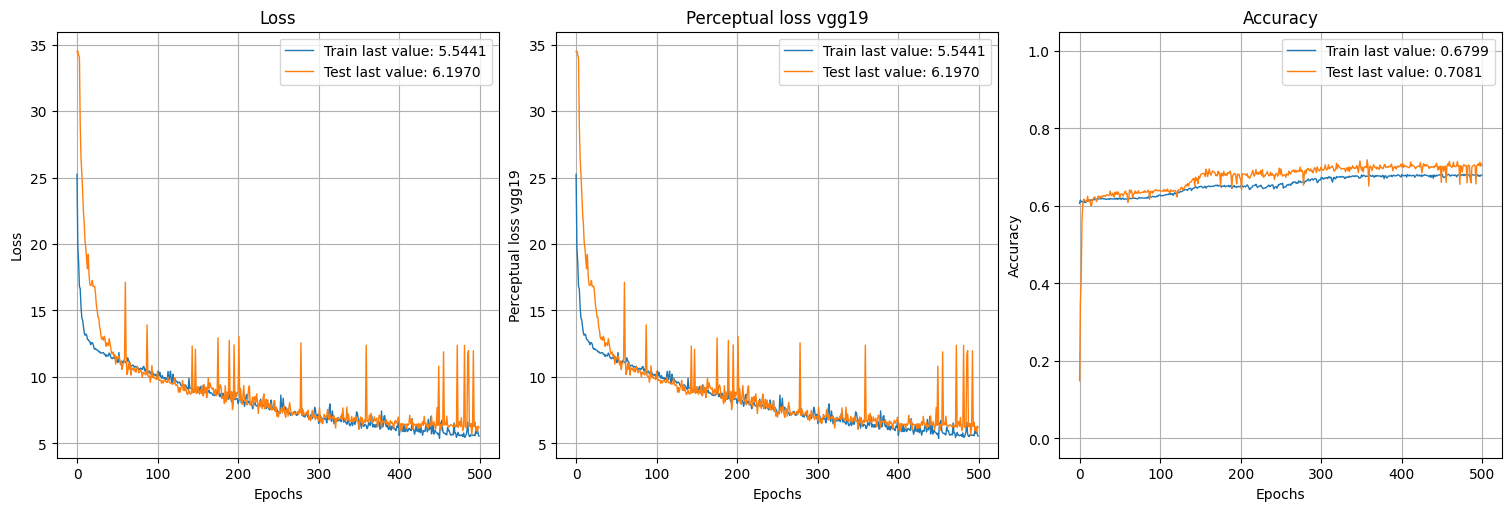

In [33]:
from plot_keras_history import show_history, plot_history
from plot_keras_history import chain_histories


# history1 = history.history
history_ =np.load('/kaggle/working/history1.npy',allow_pickle='TRUE').item()

# history_ = chain_histories(history0,history1)

show_history(history_)
plot_history(history_, path="history.png")
plt.title("VGG19")

plt.close()

# Test Model

## Evaluate metrics on Test data

In [38]:
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
# names = ["a", "b", "c"]
metrics = ['Loss', 'Perceptual Loss', 'Accuracy']
for m, r in zip(metrics, results):
    print("{} = {}".format(m, r))

Loss = 8.468233149102394
Perceptual Loss = 6.21885871887207
Accuracy = 0.6902995109558105


## Load trained model

In [27]:
# Load model
model_path = '/kaggle/working/model_unet256_vgg19.300.hdf5'
from tensorflow.keras.models import load_model

index=np.random.randint(1,len(df_test.index))
    
class CT_Reconstruction:

    def __init__(self, model_path, input_shape):
        self.unet = load_model(model_path, compile=False)
        self.input_shape = input_shape

    def preprocess_image(self, img, unet_input_shape):
        img = cv.resize(img, (256,256))
        img = img / 255
        img = img[np.newaxis, :, :, :]

        return img

    def predict(self, mri):
        img = self.preprocess_image(mri, self.input_shape)
        # Expand dimension because model expects 4 dimensional input
        pred = self.unet.predict(img)
        return pred
    
#     def evaluate(self, mri,ct ):
#         img = self.preprocess_image(mri, self.input_shape)
#         eval = self.unet.evaluate(img, ct)
#         return eval
                

    
model = CT_Reconstruction(model_path, input_shape=(256, 256, 3))

## Visualize predictions

In [28]:
# Define function for visualization
def visualize_predictions(mri,ct,pred):
    plt.figure(figsize=(12,12))
    
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(mri))
    plt.title('Input MRI')
    
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(ct))
    plt.title('Reference CT')
    
    plt.subplot(1,3,3)
    plt.imshow(pred[0], 'gray')
    plt.title('Synthetic CT')
    
    plt.show() 

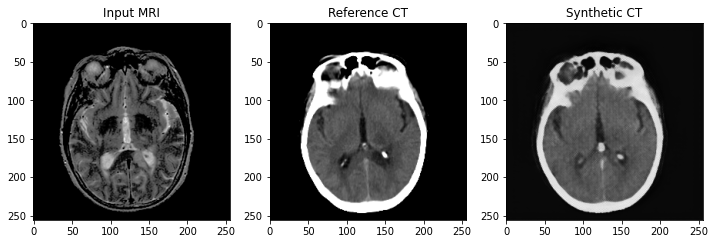

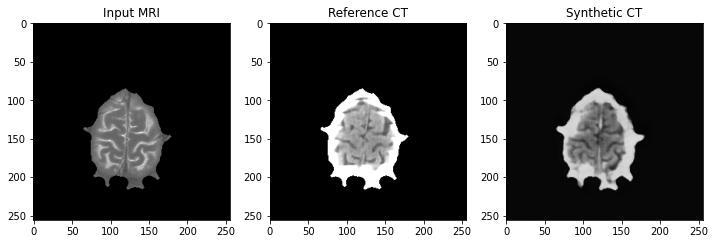

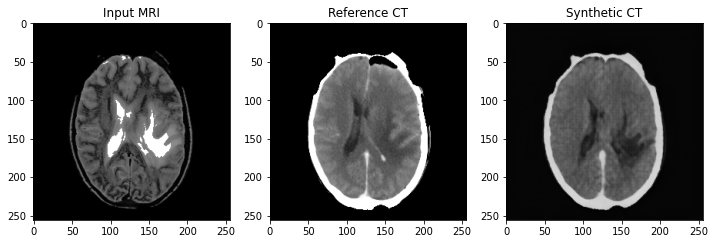

In [29]:
for i in range(3):
    index=np.random.randint(1,len(df_test.index))
    img = cv.imread(df_test['mri'].iloc[index])
    ct = cv.imread(df_test['ct'].iloc[index])
    pred=model.predict(img)

    visualize_predictions(img,ct,pred)